# 学习率调度器
:label:`sec_scheduler`

到目前为止，我们主要关注如何更新权重向量的优化算法，而不是它们的更新速率。
然而，调整学习率通常与实际算法同样重要，有如下几方面需要考虑：

* 首先，学习率的大小很重要。如果它太大，优化就会发散；如果它太小，训练就会需要过长时间，或者我们最终只能得到次优的结果。我们之前看到问题的条件数很重要（有关详细信息，请参见 :numref:`sec_momentum`）。直观地说，这是最不敏感与最敏感方向的变化量的比率。
* 其次，衰减速率同样很重要。如果学习率持续过高，我们可能最终会在最小值附近弹跳，从而无法达到最优解。 :numref:`sec_minibatch_sgd`比较详细地讨论了这一点，在 :numref:`sec_sgd`中我们则分析了性能保证。简而言之，我们希望速率衰减，但要比$\mathcal{O}(t^{-\frac{1}{2}})$慢，这样能成为解决凸问题的不错选择。
* 另一个同样重要的方面是初始化。这既涉及参数最初的设置方式（详情请参阅 :numref:`sec_numerical_stability`），又关系到它们最初的演变方式。这被戏称为*预热*（warmup），即我们最初开始向着解决方案迈进的速度有多快。一开始的大步可能没有好处，特别是因为最初的参数集是随机的。最初的更新方向可能也是毫无意义的。
* 最后，还有许多优化变体可以执行周期性学习率调整。这超出了本章的范围，我们建议读者阅读 :cite:`Izmailov.Podoprikhin.Garipov.ea.2018`来了解个中细节。例如，如何通过对整个路径参数求平均值来获得更好的解。

鉴于管理学习率需要很多细节，因此大多数深度学习框架都有自动应对这个问题的工具。
在本章中，我们将梳理不同的调度策略对准确性的影响，并展示如何通过*学习率调度器*（learning rate scheduler）来有效管理。

## 一个简单的问题

我们从一个简单的问题开始，这个问题可以轻松计算，但足以说明要义。
为此，我们选择了一个稍微现代化的LeNet版本（激活函数使用`relu`而不是`sigmoid`，汇聚层使用最大汇聚层而不是平均汇聚层），并应用于Fashion-MNIST数据集。
此外，我们混合网络以提高性能。
由于大多数代码都是标准的，我们只介绍基础知识，而不做进一步的详细讨论。如果需要，请参阅 :numref:`chap_cnn`进行复习。


In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l

# 这是一个定义LeNet模型的函数net_fn()。使用nn.Sequential来构建一个顺序的神经网络模型。该模型包含了卷积层、ReLU激活函数、池化层、全连接层等。
def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

# loss是交叉熵损失函数CrossEntropyLoss的一个实例，用于计算模型的损失。device是用于指定训练的设备（GPU或CPU），通过d2l.try_gpu()来尝试使用GPU，如果不可用则使用CPU。
loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

# batch_size是训练的批次大小。train_iter和test_iter是使用d2l.load_data_fashion_mnist函数加载的训练和测试数据集的迭代器。
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 代码几乎与d2l.train_ch6定义在卷积神经网络一章LeNet一节中的相同
# train()函数是用于训练模型的函数。net是模型，train_iter和test_iter是训练和测试数据集的迭代器，num_epochs是要训练的总轮数，loss是损失函数，trainer是优化器，device是设备指定，scheduler是学习率调度器（可选）。
# net.to(device)将模型移动到指定的设备上（GPU或CPU）。animator是一个用于绘制训练过程中损失和准确率变化的动画对象。
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    
    # 这部分代码是进行模型训练的主要循环。通过num_epochs迭代训练数据集。metric是一个用于累加训练损失、准确率和样本数量的累加器。
    # 在每个迭代步骤中，net.train()设置模型为训练模式，trainer.zero_grad()清除之前迭代步骤中的梯度，X和y是当前批次的输入和标签，通过X.to(device)和y.to(device)将其移动到指定设备上。
    # 通过net(X)进行前向传播得到预测结果y_hat，通过loss(y_hat, y)计算损失l，然后通过l.backward()进行反向传播计算梯度，并通过trainer.step()更新模型参数。
    # 使用torch.no_grad()包装的代码块用于计算并累加训练损失、准确率和样本数量。train_loss和train_acc计算平均训练损失和准确率。
    # animator.add()用于更新动画对象，绘制训练损失和准确率的变化曲线。
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss,train_acc,num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        # 在每个迭代步骤之后，使用测试数据集评估模型的准确率，并通过animator.add()更新动画对象，绘制测试准确率的变化曲线。
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        # 如果提供了学习率调度器scheduler，则在每个迭代步骤之后进行学习率的调度。如果scheduler是PyTorch内置的学习率调度器，使用scheduler.step()来更新学习率。否则，对于自定义的学习率调度器，通过遍历优化器的参数组，设置每个参数组的学习率为scheduler(epoch)。
        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # UsingPyTorchIn-Builtscheduler
                scheduler.step()
            else:
                # Usingcustomdefinedscheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)
                    
    # 在训练结束后，打印最终的训练损失、训练准确率和测试准确率。
    # 以上就是这段代码的逐行解析。它展示了一个完整的LeNet模型在Fashion MNIST数据集上的训练过程，并使用动画对象Animator实时可视化训练和测试的指标变化。
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

让我们来看看如果使用默认设置，调用此算法会发生什么。
例如设学习率为$0.3$并训练$30$次迭代。
留意在超过了某点、测试准确度方面的进展停滞时，训练准确度将如何继续提高。
两条曲线之间的间隙表示过拟合。


train loss 0.153, train acc 0.941, test acc 0.879


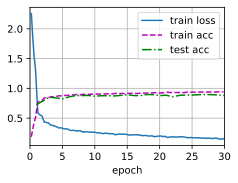

In [2]:
# 这行代码将学习率lr设置为0.3，将迭代轮数num_epochs设置为30。
lr, num_epochs = 0.3, 30
# 这行代码调用了net_fn()函数来创建模型net。
net = net_fn()
# 这行代码使用随机梯度下降（SGD）作为优化器，并将模型net的参数和学习率lr传递给优化器trainer。
trainer = torch.optim.SGD(net.parameters(), lr=lr)
# 这行代码调用了train()函数，开始训练模型。它传递了模型net、训练数据集迭代器train_iter、测试数据集迭代器test_iter、迭代轮数num_epochs、损失函数loss、优化器trainer和设备device。
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

## 学习率调度器

我们可以在每个迭代轮数（甚至在每个小批量）之后向下调整学习率。
例如，以动态的方式来响应优化的进展情况。


In [3]:
#  这行代码将学习率 lr 设置为 0.1。
lr = 0.1
# 这行代码将优化器 trainer 中的第一个参数组（通常对应于模型的所有权重和偏置项）的学习率设置为 lr。
trainer.param_groups[0]["lr"] = lr
# 这行代码打印出学习率的当前值。使用 f-string 格式化字符串，将学习率的值插入到打印语句中。.2f 表示将学习率格式化为保留两位小数的浮点数。
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

# 这行代码打印出学习率的当前值。使用 f-string 格式化字符串，将学习率的值插入到打印语句中。.2f 表示将学习率格式化为保留两位小数的浮点数。
# 总结起来，这段代码的目的是将优化器 trainer 中的学习率设置为 0.1，并打印出更新后的学习率值。这可以用于动态地调整学习率并检查更改是否成功。请注意，这段代码假设 trainer 是一个有效的优化器对象，并且至少有一个参数组。确保在运行这段代码之前，trainer 已正确初始化并包含要优化的模型的参数组。

learning rate is now 0.10


更通常而言，我们应该定义一个调度器。
当调用更新次数时，它将返回学习率的适当值。
让我们定义一个简单的方法，将学习率设置为$\eta = \eta_0 (t + 1)^{-\frac{1}{2}}$。


In [4]:
# 这段代码定义了一个名为 SquareRootScheduler 的类。它具有一个构造函数 __init__，其中 lr 是学习率的初始值，默认为 0.1。在构造函数中，将传入的 lr 值存储为对象的属性 self.lr。
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr
        
    # 这段代码定义了类中的 __call__ 方法，使得类的实例可以被调用。__call__ 方法接受一个参数 num_update，表示当前的更新次数或迭代次数。在方法内部，它计算并返回一个学习率，该学习率是根据当前迭代次数调整的。
    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)
    
    # 这段代码定义了类中的 __call__ 方法，使得类的实例可以被调用。__call__ 方法接受一个参数 num_update，表示当前的更新次数或迭代次数。在方法内部，它计算并返回一个学习率，该学习率是根据当前迭代次数调整的。

    # 具体而言，这段代码实现了一个学习率调度器，该调度器根据迭代次数的平方根来动态调整学习率。通过将迭代次数加 1.0 并将其平方根作为指数，然后将其乘以初始学习率 self.lr，得到调整后的学习率。

    # 总结起来，这段代码定义了一个学习率调度器类 SquareRootScheduler，并实现了根据迭代次数平方根动态调整学习率的逻辑。你可以根据需要创建一个该类的实例，并通过调用实例来获取不同迭代次数下的学习率。

让我们在一系列值上绘制它的行为。


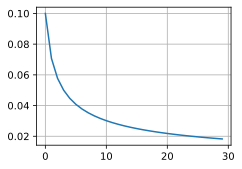

In [5]:
# 这行代码创建了一个 SquareRootScheduler 类的实例，并将学习率 lr 设置为 0.1。这个实例可以用来动态调整学习率。
scheduler = SquareRootScheduler(lr=0.1)
# 这行代码使用 d2l.plot() 函数来绘制学习率调度器在迭代次数范围内的学习率变化。torch.arange(num_epochs) 生成一个从 0 到 num_epochs-1 的张量，表示迭代次数。
# 通过列表推导式 [scheduler(t) for t in range(num_epochs)]，计算每个迭代次数对应的学习率，并将这些学习率传递给 d2l.plot() 函数进行绘制。
# 总结起来，这段代码创建了一个 SquareRootScheduler 类的实例，并使用 d2l.plot() 函数绘制了学习率调度器在迭代次数范围内的学习率变化图。这有助于可视化学习率的动态调整情况，以便更好地理解学习率的变化趋势。
# 请注意，d2l.plot() 函数可能是自定义的绘图函数，它不属于 Python 或 PyTorch 的标准库。
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

现在让我们来看看这对在Fashion-MNIST数据集上的训练有何影响。
我们只是提供调度器作为训练算法的额外参数。


train loss 0.284, train acc 0.897, test acc 0.879


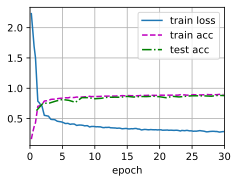

In [6]:
# 这行代码调用了 net_fn() 函数，创建了一个模型 net。
net = net_fn()
# 这行代码创建了一个随机梯度下降（SGD）优化器 trainer，并将模型 net 的参数和学习率 lr 传递给它。
trainer = torch.optim.SGD(net.parameters(), lr)
# 这行代码调用了 train() 函数，用于训练模型。它传递了模型 net、训练数据集迭代器 train_iter、
# 测试数据集迭代器 test_iter、迭代轮数 num_epochs、损失函数 loss、优化器 trainer、设备 device，以及可选的学习率调度器 scheduler。
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

这比以前好一些：曲线比以前更加平滑，并且过拟合更小了。
遗憾的是，关于为什么在理论上某些策略会导致较轻的过拟合，有一些观点认为，较小的步长将导致参数更接近零，因此更简单。
但是，这并不能完全解释这种现象，因为我们并没有真正地提前停止，而只是轻柔地降低了学习率。

## 策略

虽然我们不可能涵盖所有类型的学习率调度器，但我们会尝试在下面简要概述常用的策略：多项式衰减和分段常数表。
此外，余弦学习率调度在实践中的一些问题上运行效果很好。
在某些问题上，最好在使用较高的学习率之前预热优化器。

### 单因子调度器

多项式衰减的一种替代方案是乘法衰减，即$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$其中$\alpha \in (0, 1)$。
为了防止学习率衰减到一个合理的下界之下，
更新方程经常修改为$\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$。


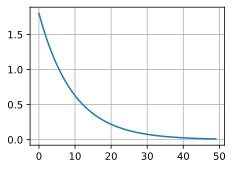

In [7]:
# 这段代码定义了一个名为 FactorScheduler 的类。它具有一个构造函数 __init__，在构造函数中，
# 它接受三个参数：factor（调整因子，默认为 1）、
# stop_factor_lr（停止调整学习率的下限，默认为 1e-7）、
# base_lr（初始学习率，默认为 0.1）。在构造函数中，
# 这些参数的值被存储为对象的属性 self.factor、self.stop_factor_lr 和 self.base_lr。
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    # 这段代码定义了类中的 __call__ 方法，使得类的实例可以被调用。__call__ 方法接受一个参数 num_update，表示当前的更新次数或迭代次数。
    # 在方法内部，它根据当前的学习率 self.base_lr 和调整因子 self.factor，更新学习率，并将其作为下一个迭代步骤的学习率返回。这里使用了 max() 函数，确保学习率不会低于 self.stop_factor_lr。
    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

# 这行代码创建了一个 FactorScheduler 类的实例 scheduler。通过传递参数 factor=0.9、stop_factor_lr=1e-2 和 base_lr=2.0，设置了调整因子、停止调整学习率的下限和初始学习率。
scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
# 这行代码使用 d2l.plot() 函数来绘制学习率调度器在迭代次数范围内的学习率变化。torch.arange(50) 生成一个从 0 到 49 的张量，表示迭代次数。
# 通过列表推导式 [scheduler(t) for t in range(50)]，计算每个迭代次数对应的学习率，并将这些学习率传递给 d2l.plot() 函数进行绘制。
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

# 总结起来，这段代码定义了一个学习率调度器类 FactorScheduler，它根据调整因子和停止调整学习率的下限动态调整学习率。
# 通过创建 FactorScheduler 类的实例，你可以获取不同迭代次数下的学习率，并使用 d2l.plot() 函数绘制学习率变化图。请注意，d2l.plot()

接下来，我们将使用内置的调度器，但在这里仅解释它们的功能。

### 多因子调度器

训练深度网络的常见策略之一是保持学习率为一组分段的常量，并且不时地按给定的参数对学习率做乘法衰减。
具体地说，给定一组降低学习率的时间点，例如$s = \{5, 10, 20\}$，
每当$t \in s$时，降低$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$。
假设每步中的值减半，我们可以按如下方式实现这一点。


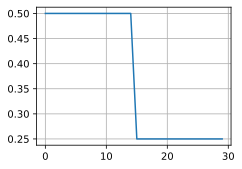

In [8]:
# 这行代码调用了 net_fn() 函数来创建一个神经网络模型 net。
net = net_fn()
# 这行代码创建了一个随机梯度下降（SGD）优化器 trainer，并将模型 net 的参数和学习率 lr=0.5 传递给它。
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
# 这行代码创建了一个多步学习率调度器 scheduler，通过传递优化器 trainer、里程碑（迭代轮数）列表 milestones=[15, 30] 和衰减因子 gamma=0.5 来初始化它。这个调度器将在特定的迭代轮数（15和30）时，将学习率乘以衰减因子。
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

# 这段代码定义了一个 get_lr() 函数，它接受优化器 trainer 和调度器 scheduler 作为输入。在函数内部，它首先通过 scheduler.get_last_lr() 获取最近一次迭代的学习率，并将学习率存储在 lr 变量中。
# 然后，它调用 trainer.step() 来更新模型的参数，调用 scheduler.step() 来更新学习率。最后，函数返回学习率 lr。
def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

# 这行代码使用 d2l.plot() 函数来绘制学习率的变化。torch.arange(num_epochs) 生成一个从 0 到 num_epochs-1 的张量，表示迭代轮数。
# 通过列表推导式 [get_lr(trainer, scheduler) for t in range(num_epochs)]，计算每个迭代轮数对应的学习率，并将这些学习率传递给 d2l.plot() 函数进行绘制。
d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler)
                                  for t in range(num_epochs)])

# 总结起来，这段代码创建了一个神经网络模型 net，使用随机梯度下降（SGD）作为优化器，并设置学习率为 0.5。然后，它创建了一个多步学习率调度器 scheduler，根据指定的里程碑（迭代轮数）和衰减因子来调整学习率。
# 最后，使用 get_lr() 函数和 d2l.plot() 函数绘制学习率在训练过程中的变化。
# 请注意，这段代码假设了一些前提条件：net_fn() 函数用于创建模型，num_epochs 是指定的迭代轮数，d2l.plot() 是用于绘图的自定义函数。确保这些前提条件已正确定义和实现，以使代码能够顺利运行。

这种分段恒定学习率调度背后的直觉是，让优化持续进行，直到权重向量的分布达到一个驻点。
此时，我们才将学习率降低，以获得更高质量的代理来达到一个良好的局部最小值。
下面的例子展示了如何使用这种方法产生更好的解决方案。


train loss 0.185, train acc 0.931, test acc 0.893


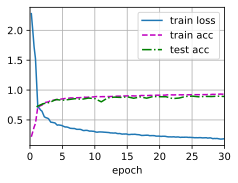

In [9]:
# 这行代码调用了 train() 函数，用于训练模型。它传递了以下参数：

# net: 神经网络模型。
# train_iter: 训练数据集的迭代器。
# test_iter: 测试数据集的迭代器。
# num_epochs: 迭代轮数。
# loss: 损失函数。
# trainer: 优化器。
# device: 训练设备。
# scheduler: 学习率调度器。
# 这行代码的作用是将上述参数传递给 train() 函数，开始模型的训练过程。在训练过程中，将使用训练数据集进行参数更新，计算损失并进行反向传播，然后使用测试数据集评估模型的性能。同时，学习率调度器将根据指定的规则动态调整学习率。

# 请注意，这段代码假设了 train() 函数已经定义并实现，能够接受这些参数并进行训练过程。确保在运行这段代码之前，train() 函数和相关的依赖项已经正确导入和定义
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### 余弦调度器

余弦调度器是 :cite:`Loshchilov.Hutter.2016`提出的一种启发式算法。
它所依据的观点是：我们可能不想在一开始就太大地降低学习率，而且可能希望最终能用非常小的学习率来“改进”解决方案。
这产生了一个类似于余弦的调度，函数形式如下所示，学习率的值在$t \in [0, T]$之间。

$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\pi t/T)\right)$$

这里$\eta_0$是初始学习率，$\eta_T$是当$T$时的目标学习率。
此外，对于$t > T$，我们只需将值固定到$\eta_T$而不再增加它。
在下面的示例中，我们设置了最大更新步数$T = 20$。


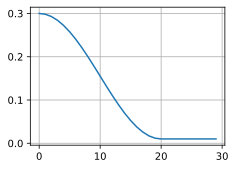

In [10]:
# 这段代码定义了一个名为 CosineScheduler 的类。它具有一个构造函数 __init__，在构造函数中，它接受一些参数来初始化学习率调度器的属性。
# 具体来说，它接受 max_update（最大迭代次数）、base_lr（初始学习率，默认为 0.01）、final_lr（最终学习率，默认为 0）、warmup_steps（热身阶段的迭代次数，默认为 0）和 warmup_begin_lr（热身阶段的初始学习率，默认为 0）。
# 它还计算了属性 max_steps，表示从热身阶段到最大迭代次数的总步数。
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    # 这段代码定义了一个 get_warmup_lr() 方法，它接受一个参数 epoch，表示当前的迭代次数。
    # 在方法内部，它计算热身阶段的学习率，根据热身阶段的初始学习率 self.warmup_begin_lr 和热身阶段的迭代次数 self.warmup_steps，通过线性插值的方式逐步增加学习率。
    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    # 这段代码定义了类中的 __call__ 方法，使得类的实例可以被调用。__call__ 方法接受一个参数 epoch，表示当前的迭代次数。
    # 在方法内部，它根据当前的迭代次数计算学习率。如果迭代次数小于热身阶段的迭代次数 self.warmup_steps，则调用 get_warmup_lr() 方法获取热身阶段的学习率。
    # 如果迭代次数在热身阶段和最大迭代次数之间，则根据余弦函数的形式计算学习率。最后，返回计算得到的学习率。
    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

# 这行代码创建了一个 CosineScheduler 类的实例 scheduler，通过传递参数 max_update=20、base_lr=0.3 和 final_lr=0.01 来设置最大迭代次数、初始学习率和最终学习率。
scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
# 这行代码使用 d2l.plot() 函数来绘制学习率的变化。torch.arange(num_epochs) 生成一个从 0 到 num_epochs-1 的张量，表示迭代次数。
# 通过列表推导式 [scheduler(t) for t in range(num_epochs)]，计算每个迭代次数对应的学习率，并将这些学习率传递给 d2l.plot() 函数进行绘制。
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

# 总结起来，这段代码定义了一个学习率调度器类 CosineScheduler，它根据余弦函数的形式动态调整学习率。通过创建 CosineScheduler 类的实例，你可以获取不同迭代次数下的学习率，并使用 d2l.plot() 函数绘制学习率变化图。
# 请注意，这段代码假设了一些前提条件：num_epochs 是指定的迭代轮数，d2l.plot() 是自定义的绘图函数，相关的代码和依赖项已经正确定义和导入。

在计算机视觉的背景下，这个调度方式可能产生改进的结果。
但请注意，如下所示，这种改进并不一定成立。


train loss 0.164, train acc 0.941, test acc 0.903


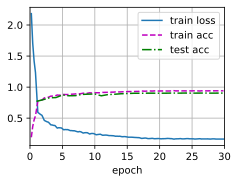

In [11]:
# 这行代码调用了 net_fn() 函数来创建一个神经网络模型 net。
net = net_fn()
# 这行代码创建了一个随机梯度下降（SGD）优化器 trainer，并将模型 net 的参数和学习率 lr=0.3 传递给它。
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
# 这行代码调用了 train() 函数，用于训练模型。它传递了以下参数：

# net: 神经网络模型。
# train_iter: 训练数据集的迭代器。
# test_iter: 测试数据集的迭代器。
# num_epochs: 迭代轮数。
# loss: 损失函数。
# trainer: 优化器。
# device: 训练设备。
# scheduler: 学习率调度器。
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

# 这行代码的作用是将上述参数传递给 train() 函数，开始模型的训练过程。在训练过程中，将使用训练数据集进行参数更新，计算损失并进行反向传播，然后使用测试数据集评估模型的性能。同时，学习率调度器将根据预定义的规则动态调整学习率。
# 请注意，这段代码假设了 net_fn() 函数已经定义并能够创建一个有效的神经网络模型，train() 函数已经定义并能够接受上述参数进行模型的训练，相关的依赖项已经正确导入。确保这些前提条件已经满足，以使代码能够顺利运行。


### 预热

在某些情况下，初始化参数不足以得到良好的解。
这对某些高级网络设计来说尤其棘手，可能导致不稳定的优化结果。
对此，一方面，我们可以选择一个足够小的学习率，
从而防止一开始发散，然而这样进展太缓慢。
另一方面，较高的学习率最初就会导致发散。

解决这种困境的一个相当简单的解决方法是使用预热期，在此期间学习率将增加至初始最大值，然后冷却直到优化过程结束。
为了简单起见，通常使用线性递增。
这引出了如下表所示的时间表。


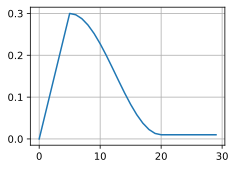

In [12]:
# 这行代码创建了一个 CosineScheduler 类的实例 scheduler。
# 通过传递参数 20 作为 max_update（最大迭代次数），
# 5 作为 warmup_steps（热身阶段的迭代次数），0.3 作为 base_lr（初始学习率），以及 0.01 作为 final_lr（最终学习率），来初始化调度器。
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
# 这行代码使用 d2l.plot() 函数绘制学习率的变化。torch.arange(num_epochs) 生成一个从 0 到 num_epochs-1 的张量，表示迭代次数。
# 通过列表推导式 [scheduler(t) for t in range(num_epochs)]，计算每个迭代次数对应的学习率，并将这些学习率传递给 d2l.plot() 函数进行绘制
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

注意，观察前5个迭代轮数的性能，网络最初收敛得更好。


train loss 0.181, train acc 0.932, test acc 0.902


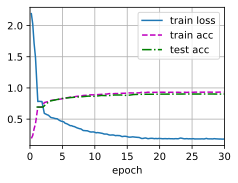

In [13]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

预热可以应用于任何调度器，而不仅仅是余弦。
有关学习率调度的更多实验和更详细讨论，请参阅 :cite:`Gotmare.Keskar.Xiong.ea.2018`。
其中，这篇论文的点睛之笔的发现：预热阶段限制了非常深的网络中参数的发散程度 。
这在直觉上是有道理的：在网络中那些一开始花费最多时间取得进展的部分，随机初始化会产生巨大的发散。

## 小结

* 在训练期间逐步降低学习率可以提高准确性，并且减少模型的过拟合。
* 在实验中，每当进展趋于稳定时就降低学习率，这是很有效的。从本质上说，这可以确保我们有效地收敛到一个适当的解，也只有这样才能通过降低学习率来减小参数的固有方差。
* 余弦调度器在某些计算机视觉问题中很受欢迎。
* 优化之前的预热期可以防止发散。
* 优化在深度学习中有多种用途。对于同样的训练误差而言，选择不同的优化算法和学习率调度，除了最大限度地减少训练时间，可以导致测试集上不同的泛化和过拟合量。

## 练习

1. 试验给定固定学习率的优化行为。这种情况下可以获得的最佳模型是什么？
1. 如果改变学习率下降的指数，收敛性会如何改变？在实验中方便起见，使用`PolyScheduler`。
1. 将余弦调度器应用于大型计算机视觉问题，例如训练ImageNet数据集。与其他调度器相比，它如何影响性能？
1. 预热应该持续多长时间？
1. 可以试着把优化和采样联系起来吗？首先，在随机梯度朗之万动力学上使用 :cite:`Welling.Teh.2011`的结果。


[Discussions](https://discuss.d2l.ai/t/4334)
